<a href="https://colab.research.google.com/github/jakebentley2001/Modelling/blob/main/Housingpricesadv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
 #Here since we are using Google colab we need to upload the file so we can read it
 
uploaded = files.upload()

Saving sample_submission.csv to sample_submission.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce
from matplotlib.pyplot import figure
import os
import geopandas as gpd
import matplotlib.colors as cl
from shapely.geometry import Point
import rtree
import pygeos
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
import seaborn as sns
from prettytable import PrettyTable
import math
from scipy import stats


In [ ]:
pip install pygeos

In [ ]:
sample_sub = pd.read_csv('sample_submission.csv')
print(sample_sub.shape)
sample_sub.head()

In [ ]:
test = pd.read_csv('test.csv')
print(test.shape)
test.head()

In [ ]:
data = pd.read_csv('train.csv')
data.head()

In [ ]:
#write a function that gets empty row count

def empty_row_count(df):

  rows, _ = df.shape
  count = []

  for c_name, e_count in df.isna().sum().iteritems():
    if e_count > 0:
      count.append((c_name, e_count, math.ceil(e_count / rows * 100)))

  table = PrettyTable(["Column Name", "Empty row count", "%"], align = "r")
  table.align["Column Name"] = "1"
  table.add_rows(sorted(count, key = lambda i : i[1], reverse = True))
  print(table)

In [ ]:
empty_row_count(data)

In [ ]:
data.drop(["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu","Id"], axis = 1, inplace = True)

In [ ]:
print(data.isna().sum().sum())

868


In [ ]:
data = data.dropna()

In [ ]:
print(data["LotFrontage"].dtype)
data["OverallCond"].dtype == 'int64'

for columns in data.columns:
  #x = data[columns].dtype == 'int64'
  print(columns)


In [ ]:
def change_type(df):

  for columns in df.columns:
    if df[columns].dtype == 'int64':
      df[columns] = df[columns].astype('float64')
    elif df[columns].dtype == 'float64':
      pass
    else:
      ce_be = ce.BinaryEncoder(cols=[columns])
      df = ce_be.fit_transform(df)
  
  return df


In [ ]:
data = change_type(data)

In [ ]:
data.shape
data.head()

In [ ]:
testdata = pd.merge(test, sample_sub, on="Id")
testdata.head()

In [ ]:
testdata.drop(["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu","Id"], axis = 1, inplace = True)

In [ ]:
testdata = change_type(testdata)

In [ ]:
#Takes out columns that don't match 
difference_list = list(set(testdata.columns) - set(data.columns))
difference_list2 = list(set(data.columns) - set(testdata.columns))
data.drop(difference_list2, axis = 1, inplace = True)
testdata.drop(difference_list, axis = 1, inplace = True)

In [ ]:
#Now they have the same columns
print(testdata.shape)
print(data.shape)

(1459, 151)
(1094, 151)


In [ ]:
b = data.loc[:,"SalePrice"]
A = data.loc[:, data.columns != 'SalePrice']
print(b.shape, A.shape)


(1094,) (1094, 150)


In [ ]:
y = [1] * len(A)
A.insert(0, "Pad", y, True)

In [ ]:
A = A.to_numpy()
b = b.to_numpy()

In [ ]:
x2 = [len(b),len(A)]
x2

[1094, 1094]

In [ ]:
p = np.random.permutation(1094)
Ap = A[p,:]
bp = b[p]

In [ ]:
Ap.shape

(1094, 151)

In [ ]:
U, S, VT = np.linalg.svd(Ap,full_matrices = 0)
x = VT.T @ np.linalg.inv(np.diag(S)) @ U.T @ bp

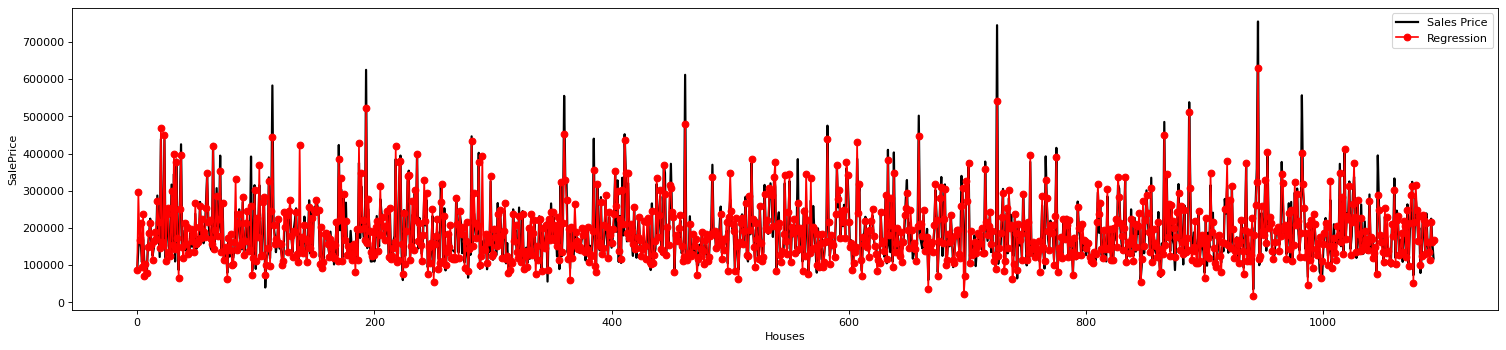

In [ ]:
figure(figsize=(23, 5), dpi=80)
#ax1 = fig.add_subplot(122)

plt.plot(bp, Color = 'k', LineWidth = 2, label = 'Sales Price')
plt.plot(Ap@x, '-o', Color = 'r', LineWidth = 1.5, MarkerSize = 6, label = "Regression") 
plt.xlabel('Houses')
plt.ylabel('SalePrice')
plt.legend()


In [ ]:
btest = testdata.loc[:,"SalePrice"]
Atest = testdata.loc[:, data.columns != 'SalePrice']

In [ ]:
y = [1] * len(Atest)
Atest.insert(0, "Pad", y, True)

In [ ]:
Atest = Atest.to_numpy()
btest = btest.to_numpy()

In [ ]:
Atest

In [ ]:
#Lets test 100 random houses
n = 1459
p = np.random.permutation(1459)
Atestp = Atest[p,:]
btestp = btest[p]
Atestp = Atestp[1:n]
btestp = btestp[1:n]

In [ ]:
Ap

array([[  1.,  30.,   0., ...,   0.,   1.,   0.],
       [  1.,  20.,   0., ...,   0.,   1.,   1.],
       [  1.,  60.,   0., ...,   0.,   0.,   1.],
       ...,
       [  1.,  60.,   0., ...,   0.,   0.,   1.],
       [  1., 190.,   0., ...,   0.,   0.,   1.],
       [  1., 190.,   0., ...,   0.,   0.,   1.]])

In [ ]:
len(x)
Atestp

array([[ 1., 85.,  0., ...,  0.,  0.,  1.],
       [ 1., 80.,  0., ...,  0.,  0.,  1.],
       [ 1., 20.,  0., ...,  0.,  0.,  1.],
       ...,
       [ 1., 60.,  0., ...,  0.,  0.,  1.],
       [ 1., 50.,  0., ...,  0.,  0.,  1.],
       [ 1., 20.,  0., ...,  0.,  1.,  1.]])

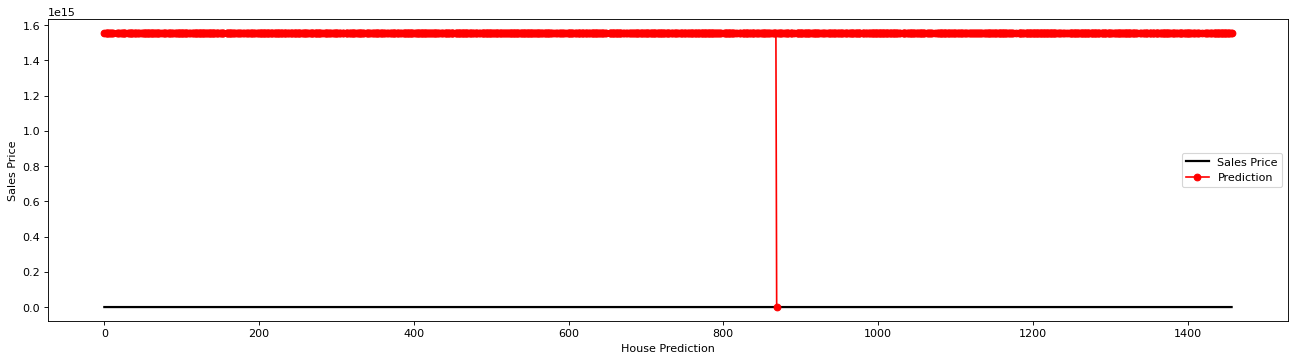

In [ ]:
#ax2 = fig.add_subplot(122)
figure(figsize=(20, 5), dpi=80)
plt.plot(btestp, Color = 'k', LineWidth = 2, label = 'Sales Price')
plt.plot(Atestp@x, '-o', Color = 'r', LineWidth = 1.5, MarkerSize = 6, label = "Prediction") 
plt.xlabel('House Prediction')
plt.ylabel('Sales Price')
plt.legend()